In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import torch
import torch.nn as nn
from torch.nn import Parameter
import sys
sys.path.append('../')
import probtorch
from probtorch.util import expand_inputs
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+f9f5c9b torch: 0.4.1 cuda: True


# Parameters

In [3]:
# model parameters
NUM_PIXELS = 784
NUM_HIDDEN = 256
NUM_LATENT = 2  

# data parameters
NUM_DATAPOINTS = 10000
NUM_TEST = 128
NUM_TRAIN = NUM_DATAPOINTS - NUM_TEST
GENDATA = False

# training parameters
NUM_SAMPLES = 1
NUM_BATCH = 128
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3
BETA1 = 0.90
EPS = 1e-9
CUDA = torch.cuda.is_available()

# path parameters
MODEL_NAME = 'bbal-%02ddim' % NUM_LATENT
DATA_PATH = './data'
WEIGHTS_PATH = '../weights'
RESTORE = False

ALPHA = 0.1
BETA = (1.0, 1.0, 1.0, 0.0, 1.0) 

# Encoder Model

In [4]:
class Encoder(nn.Module):
    def __init__(self, num_pixels=NUM_PIXELS, 
                       num_hidden=NUM_HIDDEN,
                       num_latent=NUM_LATENT):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential( 
                            nn.Linear(num_pixels, num_hidden),
                            nn.ReLU())
        self.z_mean = nn.Linear(num_hidden, num_latent)
        self.z_log_std = nn.Linear(num_hidden, num_latent)
    
    @expand_inputs
    def forward(self, images, labels=None, num_samples=NUM_SAMPLES):
        q = probtorch.Trace()
        hiddens = self.enc_hidden(images)
        q.normal(self.z_mean(hiddens),
                 self.z_log_std(hiddens).exp(),
                 name='z')
        return q

# Decoder Model

In [5]:
def binary_cross_entropy(x_mean, x, EPS=1e-9):
    return - (torch.log(x_mean + EPS) * x + 
              torch.log(1 - x_mean + EPS) * (1 - x)).sum(-1)

class Decoder(nn.Module):
    def __init__(self, num_pixels=NUM_PIXELS, 
                       num_hidden=NUM_HIDDEN,
                       num_latent=NUM_LATENT):
        super(self.__class__, self).__init__()
        
        self.dec_image = nn.Sequential(
                           nn.Linear(num_latent, num_hidden),
                           nn.ReLU(),
                           nn.Linear(num_hidden, num_pixels),
                           nn.Sigmoid())

    def forward(self, images, q=None, num_samples=NUM_SAMPLES, batch_size=NUM_BATCH, num_latent=NUM_LATENT):
        p = probtorch.Trace()
        digit_log_weights = torch.zeros(num_samples, batch_size, num_latent)
        z_mean = torch.zeros(num_samples, batch_size, num_latent)
        z_std = torch.ones(num_samples, batch_size, num_latent)
        
        if CUDA:
            digit_log_weights = digit_log_weights.cuda()
            z_mean = z_mean.cuda()
            z_std = z_std.cuda()
        
        z = p.normal(z_mean, 
                     z_std,
                     value=q['z'],
                     name='z')
        
        images_mean = self.dec_image(z)
        p.loss(binary_cross_entropy, images_mean, images, name='images')
        
        return p

# Loss

In [6]:
#def elbo(q, p, alpha=0.1):
#    if NUM_SAMPLES is None:
#        return probtorch.objectives.montecarlo.elbo(q, p, sample_dim=None, batch_dim=0, alpha=alpha)
#    else:
#        return probtorch.objectives.montecarlo.elbo(q, p, sample_dim=0, batch_dim=1, alpha=alpha)
    
def elbo(q, p, alpha=ALPHA, beta=BETA, bias=1.0):
    return probtorch.objectives.marginal.elbo(q, p, sample_dim=0, batch_dim=1,
                                              alpha=alpha, beta=beta, bias=bias)

# Data

In [7]:
from torchvision import datasets, transforms
import os 

if GENDATA:
    from ball_sim import BallSim

    sim = BallSim(timesteps=10000, dt=.1)
    sim.generate_frames(DATA_PATH+"/nolabel", img_size=np.sqrt(NUM_PIXELS), frames=NUM_DATAPOINTS)

In [12]:
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

ToGrayscaleTensor = transforms.Compose([transforms.Grayscale(), transforms.ToTensor()])
train_data = datasets.ImageFolder(root = DATA_PATH,
                                 transform = ToGrayscaleTensor)

indices = list(range(len(train_data.samples)))
test_idx = np.random.choice(indices, size=NUM_TEST, replace=False)
train_idx = list(set(indices) - set(test_idx))
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(train_data,
                                           num_workers=0,
                                           batch_size=NUM_BATCH,
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(train_data,
                                          num_workers=0,
                                          batch_size=NUM_BATCH,
                                          sampler=test_sampler)

# Training and Testing

In [13]:
def cuda_tensors(obj): 
    for attr in dir(obj):
        value = getattr(obj, attr)
        if isinstance(value, torch.Tensor):
            setattr(obj, attr, value.cuda())

enc = Encoder()
dec = Decoder()
if CUDA:
    enc.cuda()
    dec.cuda()
    cuda_tensors(enc)
    cuda_tensors(dec)

optimizer =  torch.optim.Adam(list(enc.parameters())+list(dec.parameters()),
                              lr=LEARNING_RATE,
                              betas=(BETA1, 0.999))

In [14]:
def train(data, enc, dec, optimizer):
    epoch_elbo = 0.0
    enc.train()
    dec.train()
    N = 0
    for b, (images, labels) in enumerate(data):
        if images.size()[0] == NUM_BATCH:
            N += NUM_BATCH
            images = images.view(-1, NUM_PIXELS)
            if CUDA:
                images = images.cuda()
            optimizer.zero_grad()
            q = enc(images, num_samples=NUM_SAMPLES)
            p = dec(images, q, num_samples=NUM_SAMPLES, batch_size=NUM_BATCH)
            loss = -elbo(q, p)
            loss.backward()
            optimizer.step()
            if CUDA:
                loss = loss.cpu()
            epoch_elbo -= float(loss.item())
    return epoch_elbo / N

def test(data, enc, dec):
    enc.eval()
    dec.eval()
    epoch_elbo = 0.0
    N = 0
    for b, (images, labels) in enumerate(data):
        if images.size()[0] == NUM_BATCH:
            N += NUM_BATCH
            images = images.view(-1, NUM_PIXELS)
            if CUDA:
                images = images.cuda()
            q = enc(images, num_samples=NUM_SAMPLES)
            p = dec(images, q, num_samples=NUM_SAMPLES)
            batch_elbo = elbo(q, p)
            if CUDA:
                batch_elbo = batch_elbo.cpu()
            epoch_elbo += float(batch_elbo.item())
    return epoch_elbo / N

In [16]:
import time
from random import random
if not RESTORE:
    mask = {}
    for e in range(NUM_EPOCHS):
        train_start = time.time()
        train_elbo = train(train_loader, enc, dec, optimizer)
        train_end = time.time()
        test_start = time.time()
        test_elbo = test(test_loader, enc, dec)
        test_end = time.time()
        print('[Epoch %d] Train: ELBO %.4e (%ds) Test: ELBO %.4e (%ds)' % (
                e, train_elbo, train_end - train_start, 
                test_elbo, test_end - test_start))

    if not os.path.isdir(WEIGHTS_PATH):
        os.mkdir(WEIGHTS_PATH)
    torch.save(enc.state_dict(),
               '%s/%s-%s-%s-enc.rar' % (WEIGHTS_PATH, MODEL_NAME, probtorch.__version__, torch.__version__))
    torch.save(dec.state_dict(),
               '%s/%s-%s-%s-dec.rar' % (WEIGHTS_PATH, MODEL_NAME, probtorch.__version__, torch.__version__))

[Epoch 0] Train: ELBO -1.0880e+00 (1s) Test: ELBO -1.0816e+00 (0s)
[Epoch 1] Train: ELBO -1.0727e+00 (1s) Test: ELBO -1.0616e+00 (0s)
[Epoch 2] Train: ELBO -9.7650e-01 (1s) Test: ELBO -8.9520e-01 (0s)
[Epoch 3] Train: ELBO -8.5349e-01 (1s) Test: ELBO -8.0705e-01 (0s)
[Epoch 4] Train: ELBO -7.6609e-01 (1s) Test: ELBO -7.2274e-01 (0s)
[Epoch 5] Train: ELBO -6.6853e-01 (1s) Test: ELBO -6.1827e-01 (0s)
[Epoch 6] Train: ELBO -5.9738e-01 (1s) Test: ELBO -5.6037e-01 (0s)
[Epoch 7] Train: ELBO -5.4814e-01 (1s) Test: ELBO -5.2250e-01 (0s)
[Epoch 8] Train: ELBO -5.2068e-01 (1s) Test: ELBO -4.9721e-01 (0s)
[Epoch 9] Train: ELBO -4.9322e-01 (1s) Test: ELBO -4.7364e-01 (0s)
[Epoch 10] Train: ELBO -4.8096e-01 (1s) Test: ELBO -4.5982e-01 (0s)
[Epoch 11] Train: ELBO -4.6034e-01 (1s) Test: ELBO -4.5149e-01 (0s)
[Epoch 12] Train: ELBO -4.4952e-01 (1s) Test: ELBO -4.3194e-01 (0s)
[Epoch 13] Train: ELBO -4.3775e-01 (1s) Test: ELBO -4.3255e-01 (0s)
[Epoch 14] Train: ELBO -4.3443e-01 (1s) Test: ELBO -4.1445

In [17]:
if RESTORE:
    enc.load_state_dict(torch.load('%s/%s-%s-%s-enc.rar' % (WEIGHTS_PATH, MODEL_NAME, probtorch.__version__, torch.__version__)))
    dec.load_state_dict(torch.load('%s/%s-%s-%s-dec.rar' % (WEIGHTS_PATH, MODEL_NAME, probtorch.__version__, torch.__version__)))

# Visualize Embedding

In [26]:
import numpy as np
zs = []
for (x, nolabel) in train_loader:
    #if len(x) == NUM_BATCH:
    images = x.view(-1, NUM_PIXELS)
    if CUDA:
        q = enc(images.cuda())
        z = q['z'].value
        zs.append(z.cpu().detach().numpy())
    else:
        q = enc(images)
        z = q['z'].value.data.detach().numpy()
        zs.append(z.detach().numpy())

zs = np.concatenate(zs, 0)

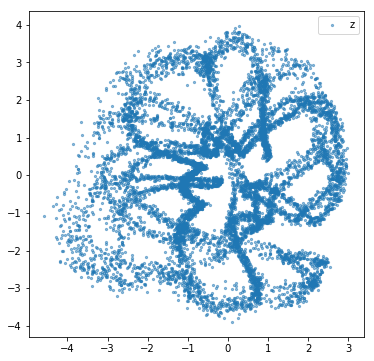

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

if NUM_LATENT==2:
    fig = plt.figure(figsize=(6,6))
    ax = plt.gca()
    p = ax.scatter(zs[:, 0], zs[:, 1], label='z', alpha=0.5, s=5)
    ax.legend()
else:
    print('Only works for 2D latent space')

# Visualize Reconstructions 

In [28]:
rs = []
xs = []
for (x, nolabel) in test_loader:
    #if len(x) == NUM_BATCH:
    images = x.view(-1, NUM_PIXELS)
    if CUDA:
        q = enc(images.cuda())
        z = q['z'].value
        r = dec.dec_image(z)
        rs.append(r.cpu().detach().numpy())
        xs.append(x.cpu().detach().numpy())
    else:
        q = enc(images)
        z = q['z'].value.data.detach().numpy()
        r = dec.dec_image(z)
        rs.append(r.detach().numpy())
        xs.append(x.detach().numpy())

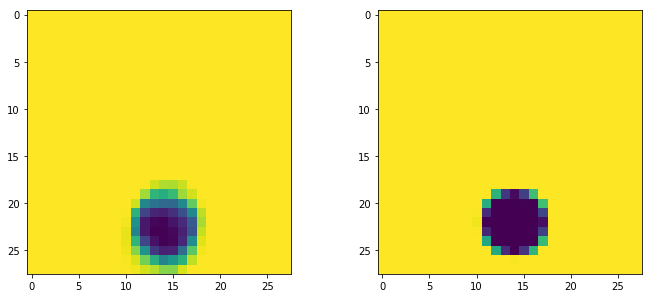

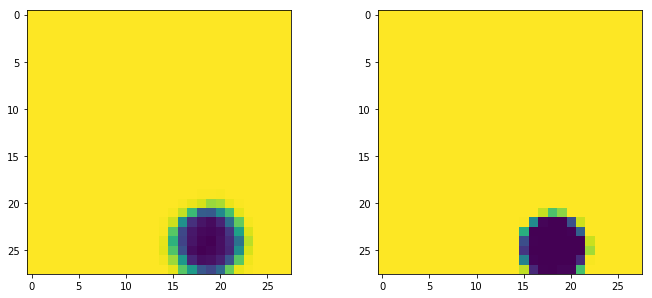

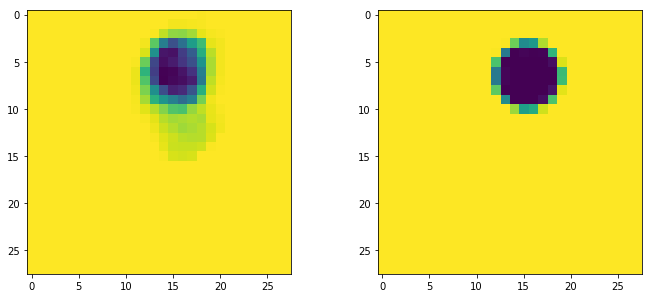

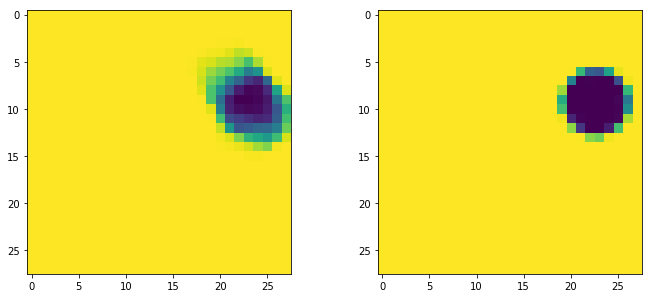

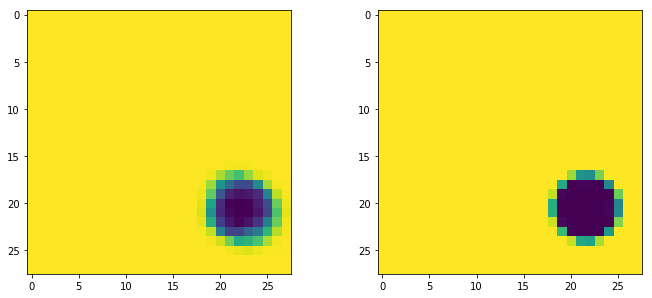

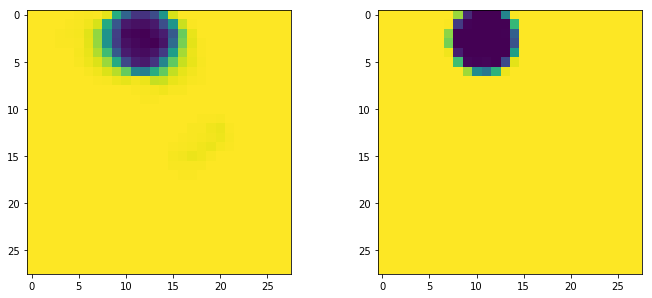

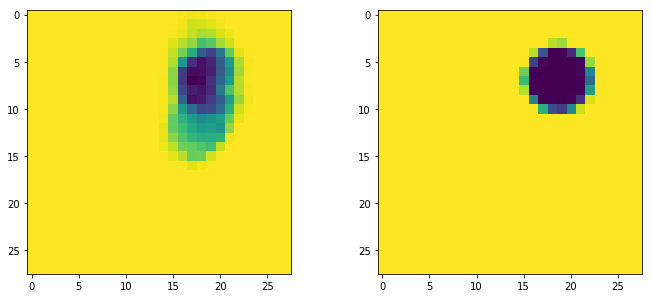

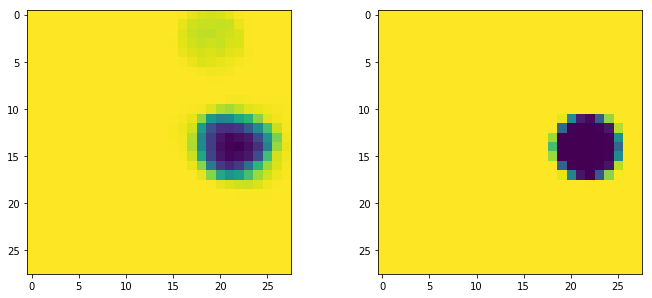

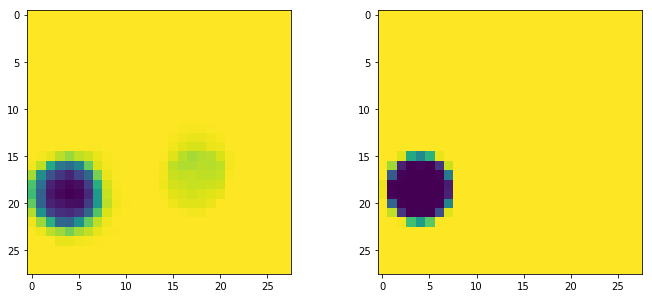

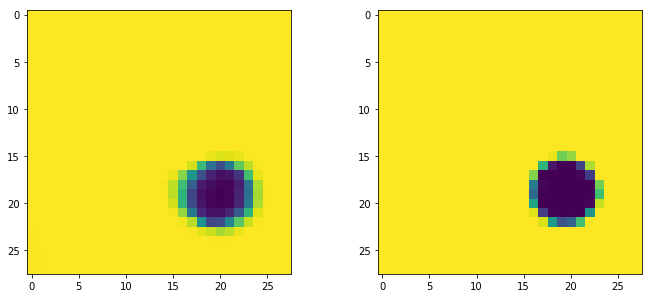

In [30]:
# Display Ball image reconstructions of Test data
for i in range(10):
    fig = plt.figure(figsize=(10,4.25))
    plt.subplot(121)
    plt.imshow(rs[0][i].reshape(28, 28))
    plt.subplot(122)
    plt.imshow(xs[0][i][0])
    fig.tight_layout()